<a href="https://colab.research.google.com/github/CReSIS/cresis-toolbox/blob/IBK/sm_Unet_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import tensorflow as tf
import os
from tensorflow import keras
import numpy as np
import random
from tensorflow.keras import backend as K
from scipy.io import loadmat,savemat
from matplotlib import pyplot as plt
from matplotlib import cm

# !pip install segmentation-models 
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [5]:
IMG_HEIGHT = 416 #224, 416
IMG_WIDTH = 64
IMG_CHANNELS = 1

# Create input 
#base_dir = 'Y:/ibikunle/Python_Env/Recreated_UMBC_data_224x64/'
# base_dir = 'Y:/ibikunle/Python_Env/jstars21_segment/'
base_dir = '/content/gdrive/MyDrive/echo_cnn_in_out_GOOD_layers'
input_dir = "/image/"
target_dir = "/segment_dir/"
img_size = (IMG_HEIGHT,IMG_WIDTH )
num_classes = 30
batch_size = 20 #13

input_img_paths = sorted( os.listdir (base_dir+ input_dir) ) 
target_img_paths = sorted( os.listdir(base_dir + target_dir) ) 

In [7]:
train_samples = 1000 # 1000        
val_samples = 400 # 500
test_samples = len(input_img_paths) - train_samples - val_samples

random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:train_samples] # input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:train_samples] # target_img_paths[:-val_samples]

val_input_img_paths = input_img_paths[train_samples:train_samples+val_samples+1] # input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[train_samples:train_samples+val_samples+1]


In [13]:
# Echo_Load_Train_Test function
class Echo_Load_Train_Test(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths,base_dir = base_dir ,input_dir = input_dir,target_dir = target_dir, num_classes = num_classes):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        self.base_dir = base_dir
        self.input_dir = input_dir
        self.target_dir = target_dir

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        
        # x = np.zeros((self.batch_size,) + self.img_size , dtype="uint8")
        x = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img_path = base_dir + input_dir + path
            img = loadmat(img_path)
            img = img['echo_tmp']
            img[np.isnan(img)] = 0
            
            if np.all(img<=1):
                x[j] = np.expand_dims( img, 2) # Normalize /255
            else:
                x[j] = np.expand_dims( img/255, 2)

        # y = np.zeros((self.batch_size,) + self.img_size , dtype="uint8")    
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="float32")
        for j, path in enumerate(batch_target_img_paths):
            target_path = base_dir + target_dir + path
            target = loadmat(target_path)
            target = target['semantic_seg'] #raster
            target = ( np.array(target) ).astype('int') #,dtype=bool
            y[j] = np.expand_dims( target, 2 )
        y = tf.keras.utils.to_categorical(y, num_classes)
        return x, y  


In [14]:
# Instantiate training and testing data
train_gen = Echo_Load_Train_Test(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = Echo_Load_Train_Test(batch_size, img_size, val_input_img_paths, val_target_img_paths)

if test_samples > 1:
    test_input_img_paths = input_img_paths[-test_samples:] # input_img_paths[-val_samples:]
    test_target_img_paths = target_img_paths[-test_samples:]
    test_gen = Echo_Load_Train_Test(batch_size, img_size, test_input_img_paths, test_target_img_paths)

In [8]:
BACKBONE = 'resnet50'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
sm_model = sm.Unet(backbone_name='resnet50', encoder_weights=None, input_shape=(None, None, IMG_CHANNELS), classes=30, activation='softmax')

In [ ]:
sm_model.compile(
    'NAdam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score,'accuracy'],
)


In [ ]:
epochs = 10
sm_model.fit(train_gen, epochs=epochs, validation_data=val_gen) 

Epoch 1/10
50/50 [==============================] - 971s 19s/step - loss: 0.3831 - iou_score: 0.6417 - accuracy: 0.9102 - val_loss: 0.4521 - val_iou_score: 0.5788 - val_accuracy: 0.8854
Epoch 2/10
50/50 [==============================] - 952s 19s/step - loss: 0.3423 - iou_score: 0.6782 - accuracy: 0.9239 - val_loss: 0.3856 - val_iou_score: 0.6393 - val_accuracy: 0.9116
Epoch 3/10
50/50 [==============================] - 975s 20s/step - loss: 0.2926 - iou_score: 0.7257 - accuracy: 0.9369 - val_loss: 0.3290 - val_iou_score: 0.6925 - val_accuracy: 0.9237
Epoch 4/10
50/50 [==============================] - 971s 19s/step - loss: 0.2691 - iou_score: 0.7476 - accuracy: 0.9426 - val_loss: 0.3314 - val_iou_score: 0.6934 - val_accuracy: 0.9151
Epoch 5/10
50/50 [==============================] - 965s 19s/step - loss: 0.2501 - iou_score: 0.7654 - accuracy: 0.9464 - val_loss: 0.3114 - val_iou_score: 0.7101 - val_accuracy: 0.9233
Epoch 6/10
50/50 [==============================] - 969s 19s/step - lo

In [ ]:
if 0:
  sm_model.save('/content/gdrive/MyDrive/echo_cnn_in_out_GOOD_layers/SM_UNet_ResNet50_segment_96percent_210621')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/echo_cnn_in_out_GOOD_layers/SM_UNet_ResNet50_segment_96percent_210621/assets


In [ ]:
# Save model summary as text
from contextlib import redirect_stdout

with open('/content/gdrive/MyDrive/echo_cnn_in_out_GOOD_layers/modelsummary.txt', 'w') as f:
    with redirect_stdout(f):
        sm_model.summary()

In [ ]:
if 0:
  loaded_model = tf.keras.models.load_model('/content/gdrive/MyDrive/echo_cnn_in_out_GOOD_layers/SM_UNet_ResNet50_segment_96percent_210621',custom_objects={'binary_crossentropy_plus_jaccard_loss': sm.losses.bce_jaccard_loss, 'iou_score':sm.metrics.iou_score})

 

image_000755_dec_segment.mat
image_001583_dec_segment.mat
image_000858_dec_segment.mat
image_000553_dec_segment.mat
image_000703_dec_segment.mat
image_000569_dec_segment.mat
image_000730_dec_segment.mat
image_000997_dec_segment.mat
image_001461_dec_segment.mat


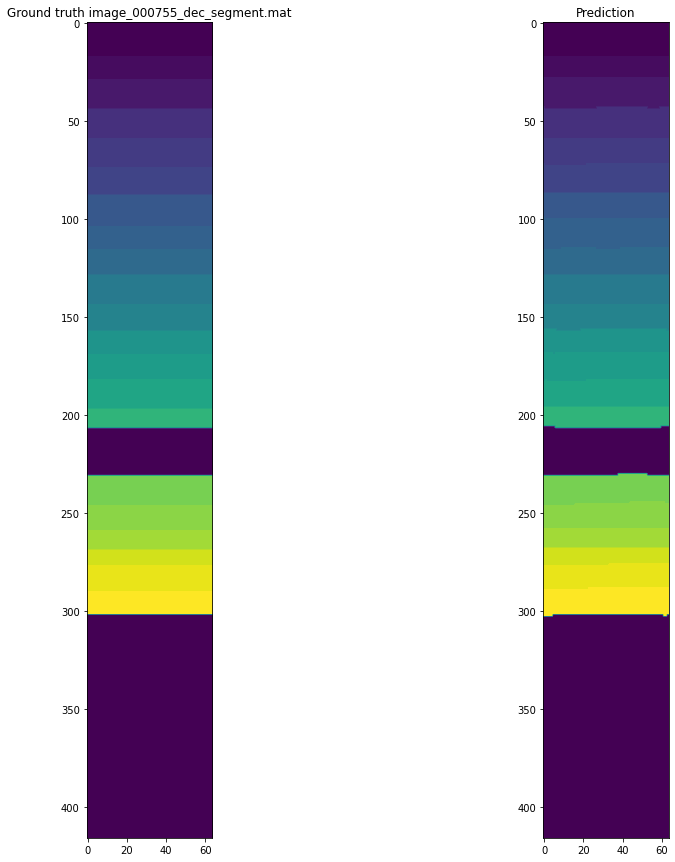

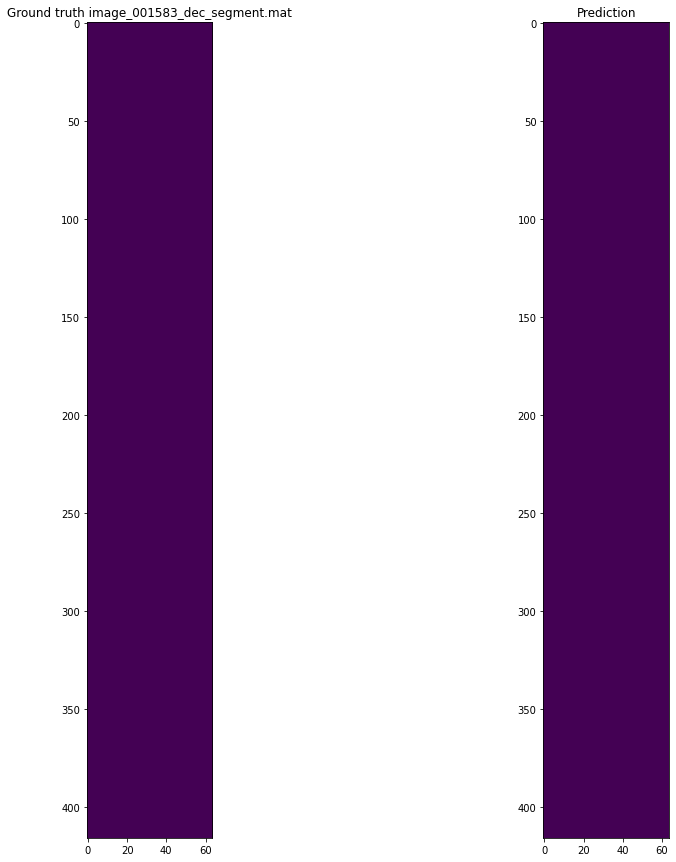

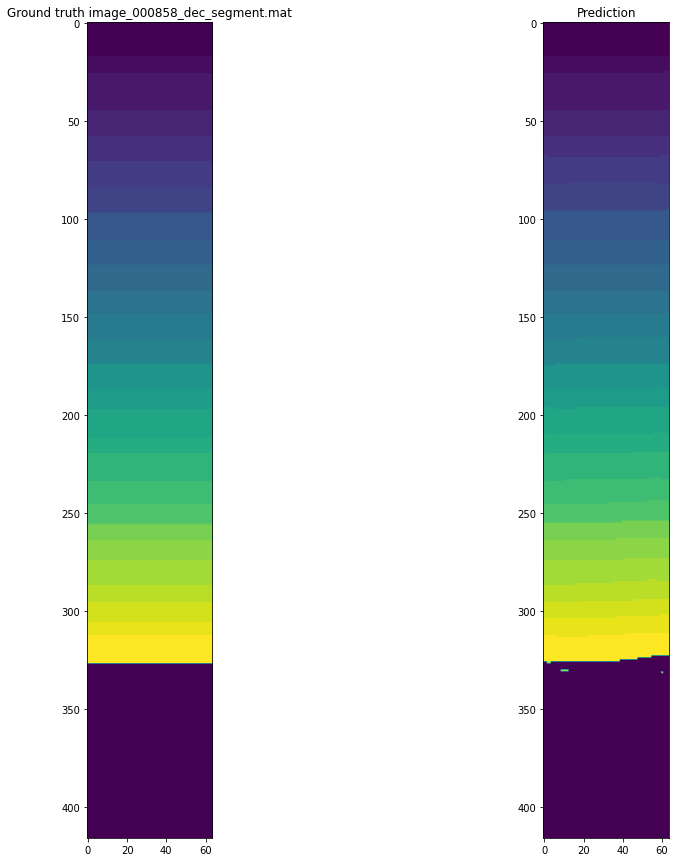

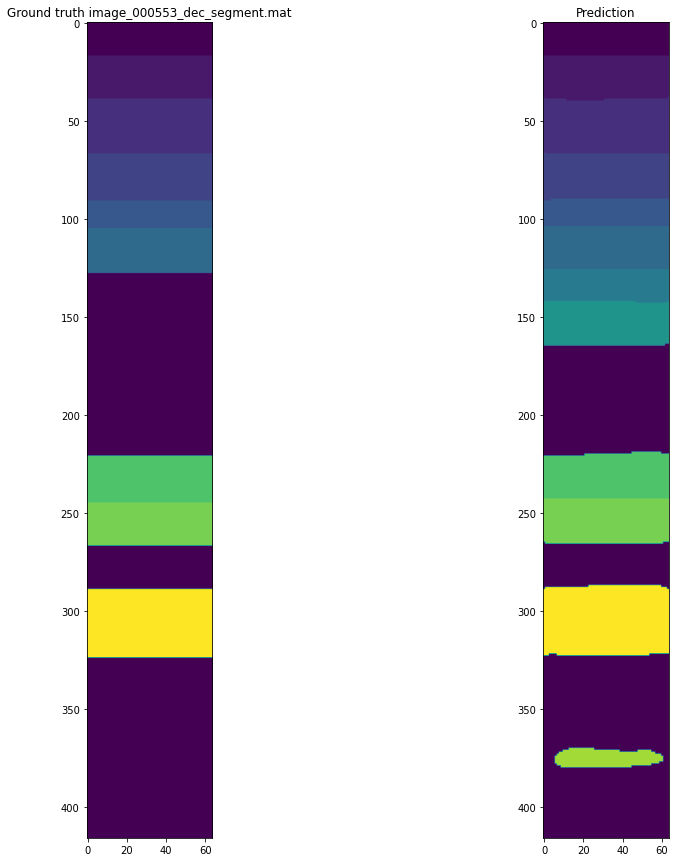

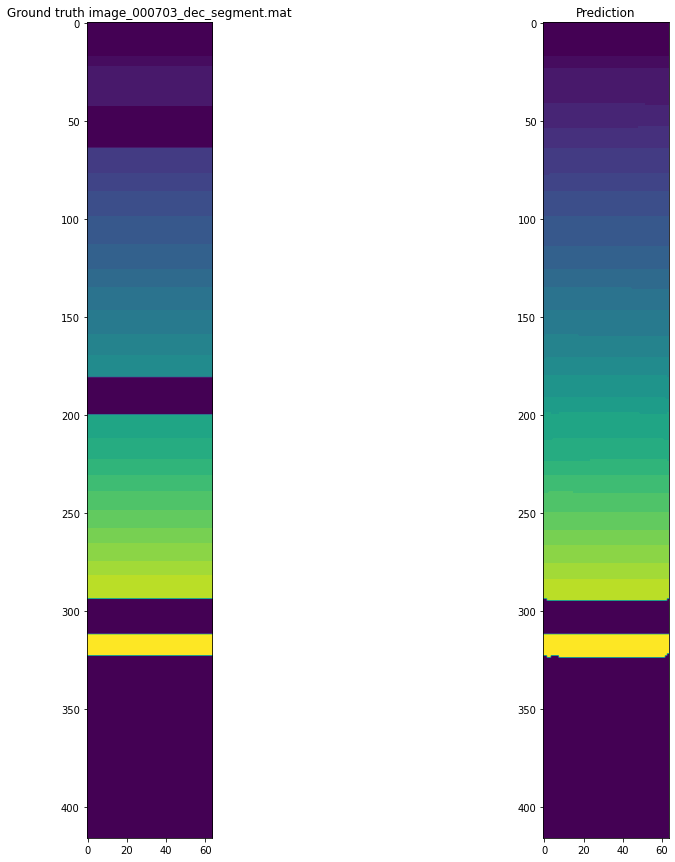

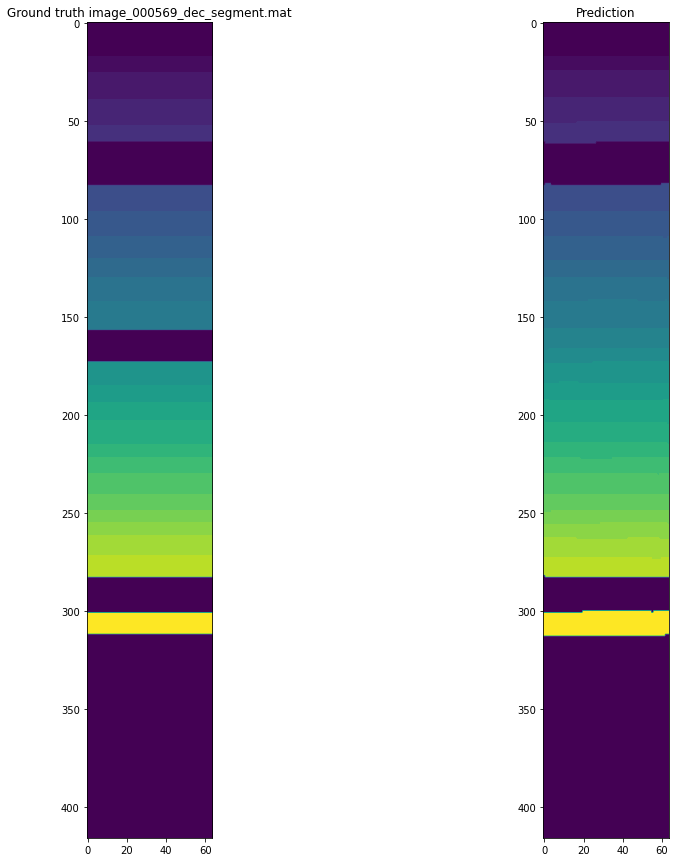

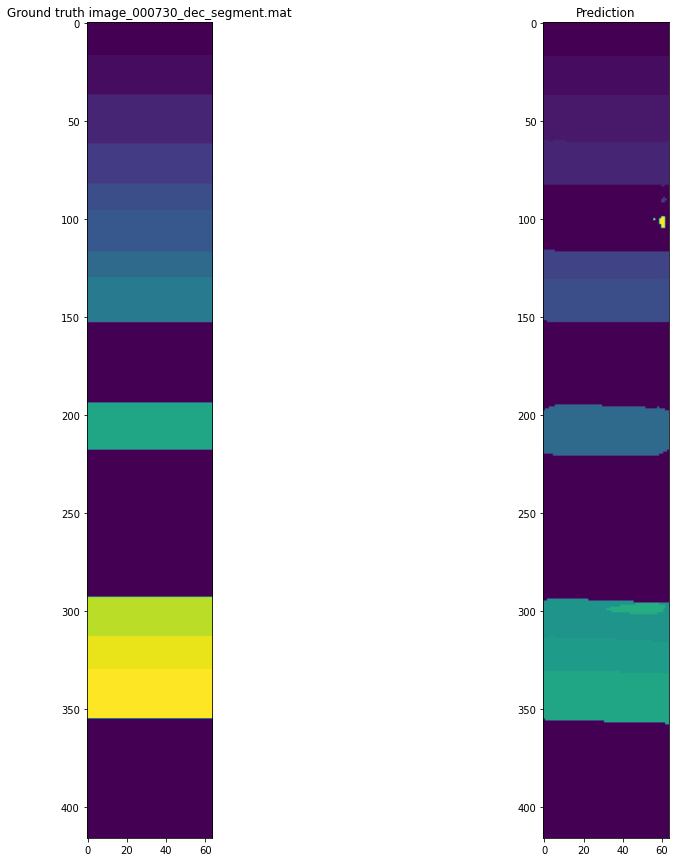

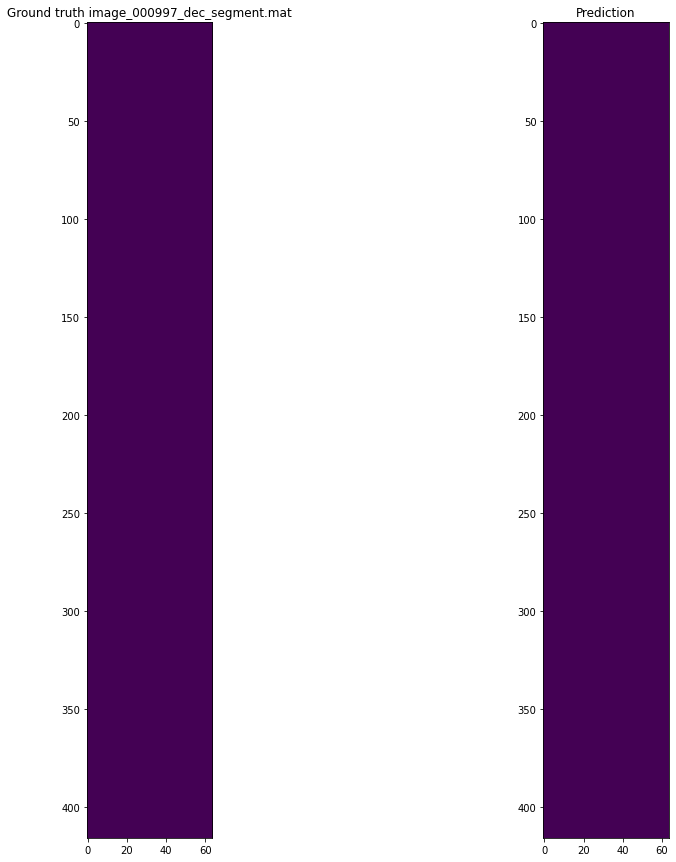

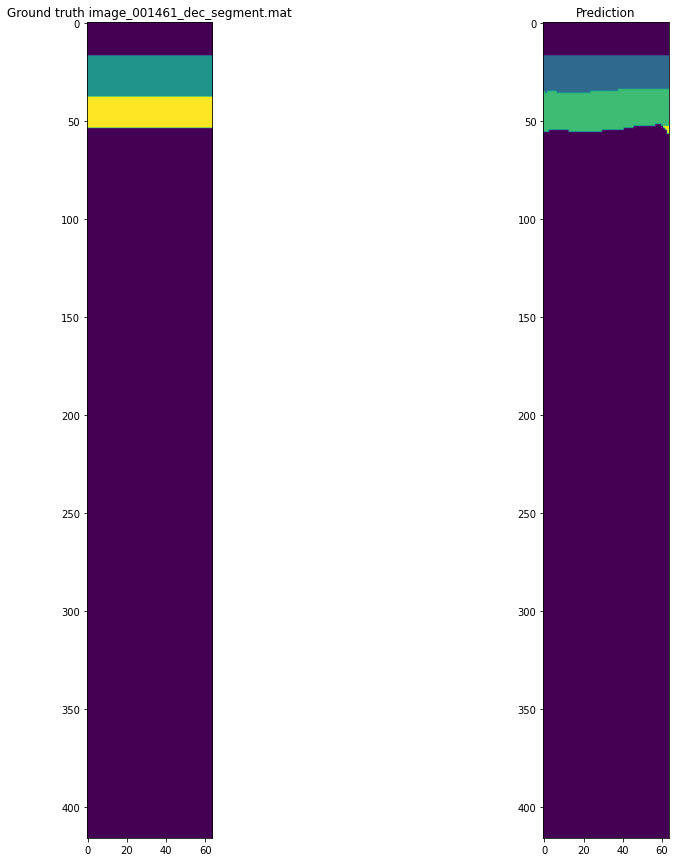

In [ ]:
# Visualize some prediction
import random

batch_idx = random.randint(1,batch_size) # Pick any of the default batch

a,a_gt = train_gen[batch_idx]
for idx in range(1,10):
  a0 = a[idx]
  a_gt0 = a_gt[idx]
  # ( a0.shape, a_gt0.shape )

  res0 = loaded_model.predict ( np.expand_dims(a0,axis=0) )
  res0_argmax = np.argmax(res0,axis=3)
  res0_final = res0_argmax.squeeze()

  idx3 = 20*batch_idx +idx
  gt = loadmat(base_dir+target_dir+train_target_img_paths[idx3])
  print(train_target_img_paths[idx])
  gt = gt['semantic_seg']

  f, axarr = plt.subplots(1,2,figsize=(15,15))
  axarr[0].imshow(gt,cmap=cm.get_cmap('viridis', 30))
  axarr[0].set_title( f'Ground truth {train_target_img_paths[idx]}') #.set_text

  axarr[1].imshow(res0_final, cmap=cm.get_cmap('viridis', 30) )
  axarr[1].set_title('Prediction') #.set_text


In [ ]:
## Evaluate on test and validation set and save result to disk
if 0:
  val_result = loaded_model.predict(val_gen)
  test_result = loaded_model.predict(test_gen)

  SM_seg_result = {}
  SM_seg_result['val_paths'] = val_input_img_paths
  SM_seg_result['test_paths'] = test_input_img_paths

  SM_seg_result['val_result'] = val_result
  SM_seg_result['test_result'] = test_result

  savemat('/content/gdrive/MyDrive/echo_cnn_in_out_GOOD_layers/SM_UNet_predictions.mat',SM_seg_result)

In [10]:
# Another model (FPN)
sm_FPNmodel = sm.FPN(backbone_name='resnet50', encoder_weights=None, input_shape=(None, None, IMG_CHANNELS), classes=30, activation='softmax')

sm_FPNmodel.compile(
    'NAdam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score,'accuracy'],
)

In [16]:
epochs = 10
sm_FPNmodel.fit(train_gen, epochs=epochs, validation_data=val_gen) 

Epoch 1/10
50/50 [==============================] - 1456s 29s/step - loss: 0.1883 - iou_score: 0.8211 - accuracy: 0.9618 - val_loss: 0.2438 - val_iou_score: 0.7734 - val_accuracy: 0.9377
Epoch 2/10
50/50 [==============================] - 1452s 29s/step - loss: 0.1868 - iou_score: 0.8224 - accuracy: 0.9633 - val_loss: 0.2294 - val_iou_score: 0.7862 - val_accuracy: 0.9442
Epoch 3/10
50/50 [==============================] - 1458s 29s/step - loss: 0.1800 - iou_score: 0.8286 - accuracy: 0.9659 - val_loss: 0.2222 - val_iou_score: 0.7920 - val_accuracy: 0.9458
Epoch 4/10
50/50 [==============================] - 1452s 29s/step - loss: 0.1717 - iou_score: 0.8363 - accuracy: 0.9684 - val_loss: 0.2068 - val_iou_score: 0.8063 - val_accuracy: 0.9521
Epoch 5/10
50/50 [==============================] - 1447s 29s/step - loss: 0.1658 - iou_score: 0.8416 - accuracy: 0.9705 - val_loss: 0.2497 - val_iou_score: 0.7684 - val_accuracy: 0.9323
Epoch 6/10
50/50 [==============================] - 1460s 29s/ste

image_001702_dec_segment.mat
image_000646_dec_segment.mat
image_000482_dec_segment.mat
image_000369_dec_segment.mat
image_000257_dec_segment.mat
image_000205_dec_segment.mat
image_000654_dec_segment.mat
image_001462_dec_segment.mat
image_000852_dec_segment.mat


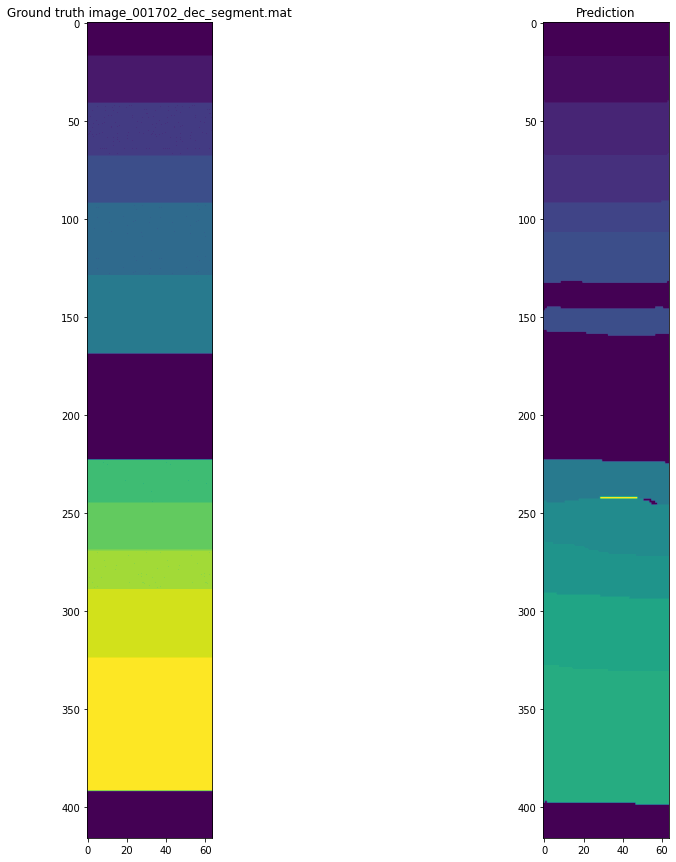

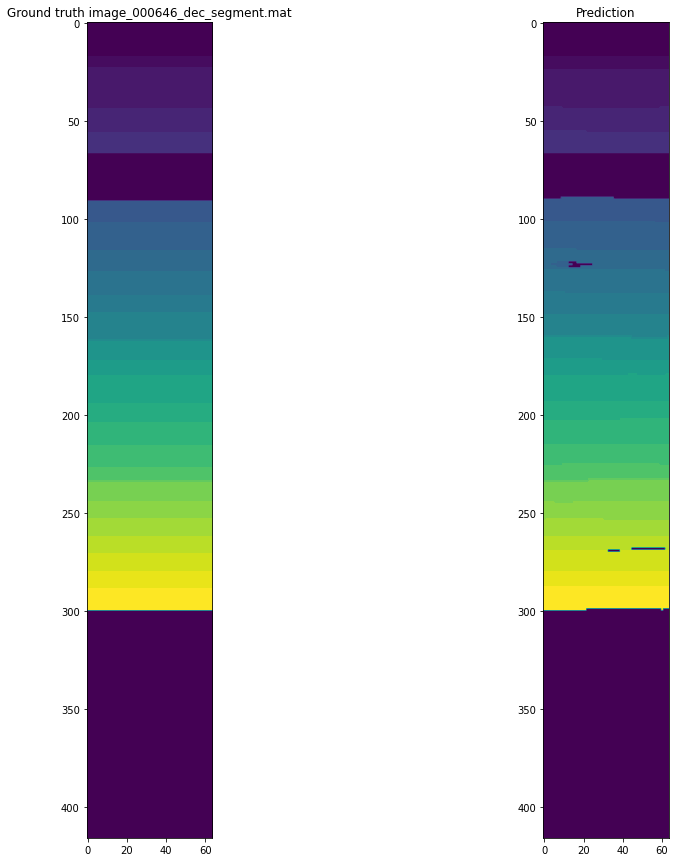

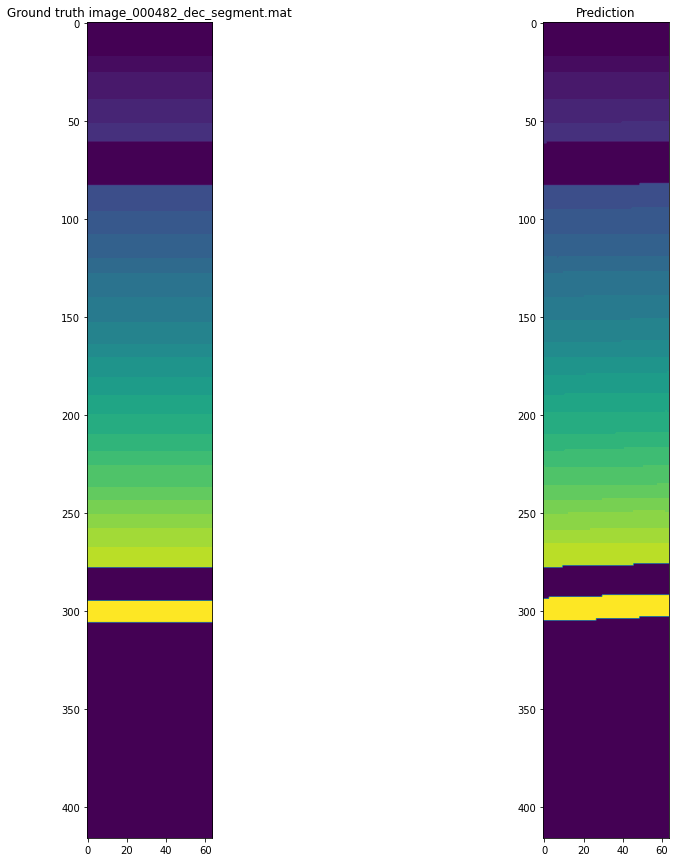

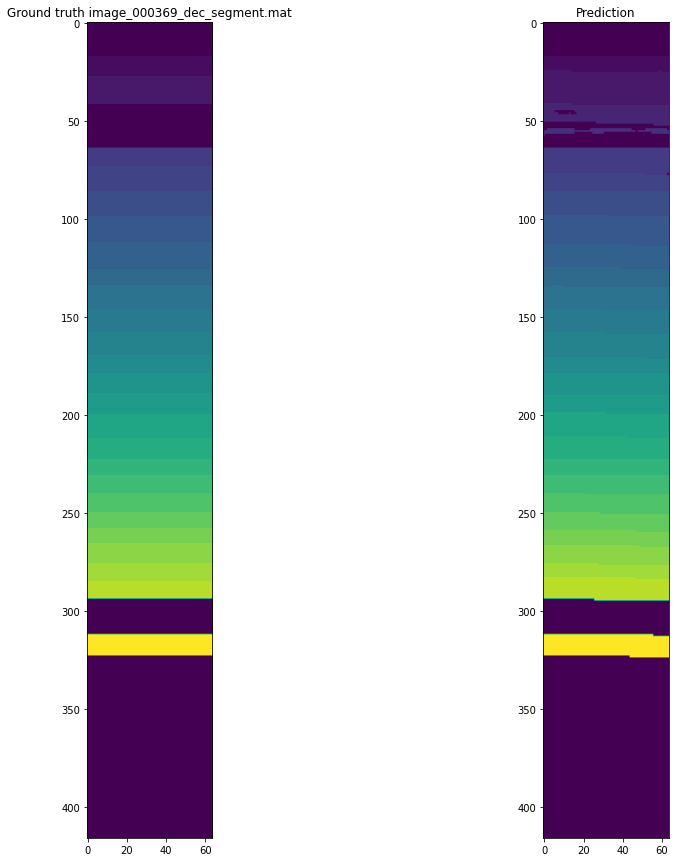

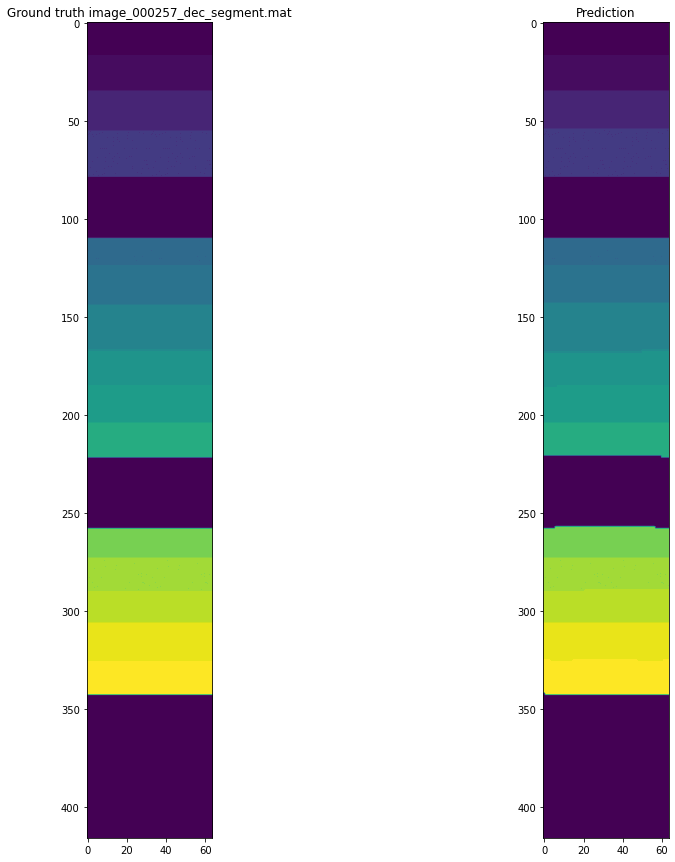

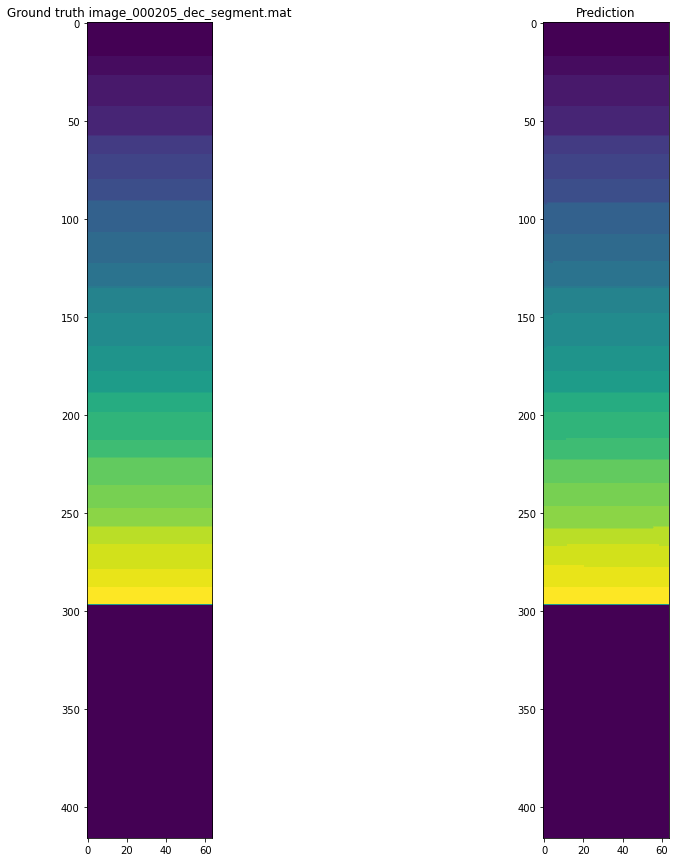

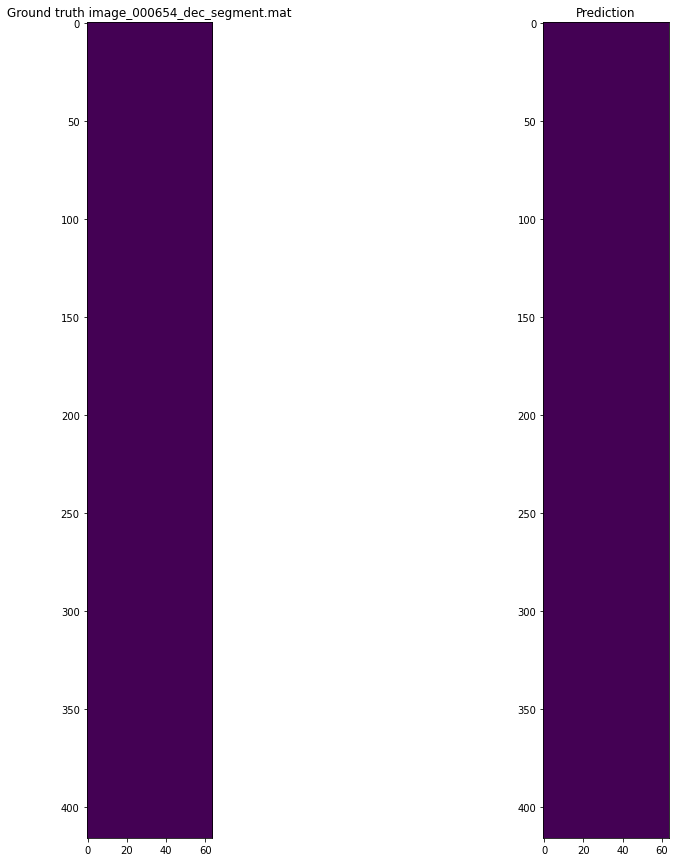

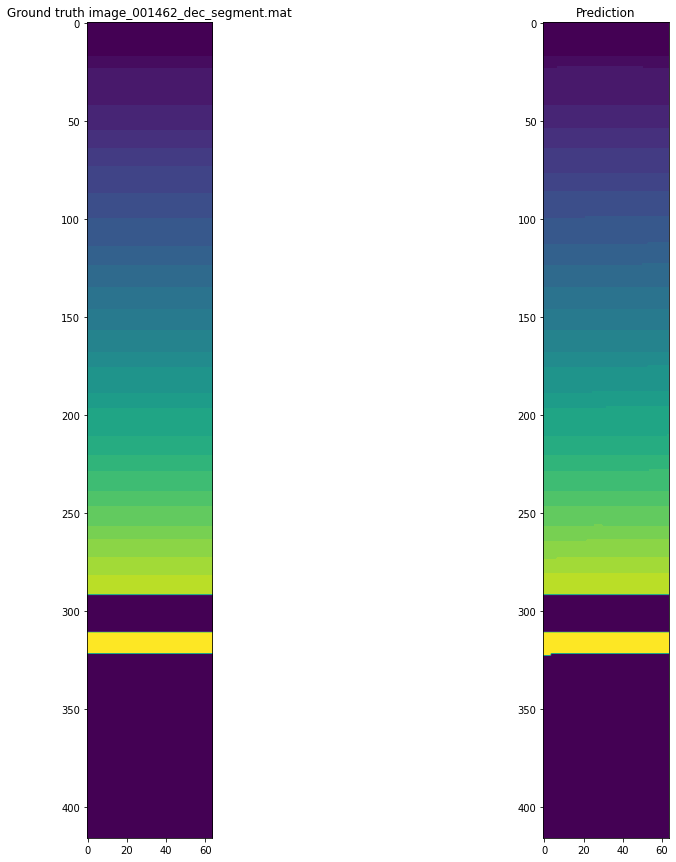

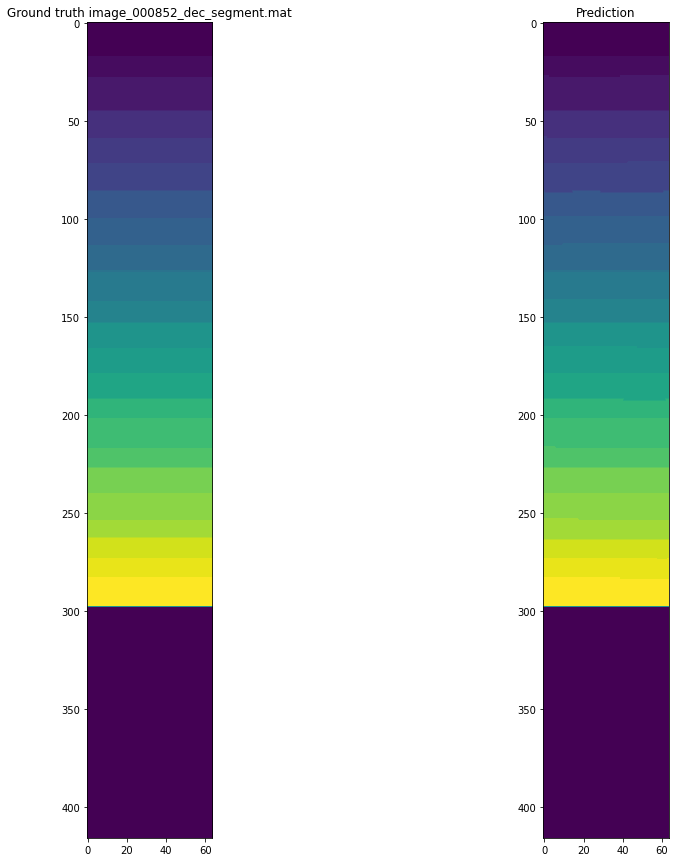

In [17]:
# FPN predictions
import random

batch_idx = random.randint(1,batch_size) # Pick any of the default batch

a,a_gt = train_gen[batch_idx]
for idx in range(1,10):
  a0 = a[idx]
  a_gt0 = a_gt[idx]
  # ( a0.shape, a_gt0.shape )

  res0 = sm_FPNmodel.predict ( np.expand_dims(a0,axis=0) )
  res0_argmax = np.argmax(res0,axis=3)
  res0_final = res0_argmax.squeeze()

  idx3 = 20*batch_idx +idx
  gt = loadmat(base_dir+target_dir+train_target_img_paths[idx3])
  print(train_target_img_paths[idx])
  gt = gt['semantic_seg']

  f, axarr = plt.subplots(1,2,figsize=(15,15))
  axarr[0].imshow(gt,cmap=cm.get_cmap('viridis', 30))
  axarr[0].set_title( f'Ground truth {train_target_img_paths[idx]}') #.set_text

  axarr[1].imshow(res0_final, cmap=cm.get_cmap('viridis', 30) )
  axarr[1].set_title('Prediction') #.set_text

In [18]:
sm_FPNmodel.save('/content/gdrive/MyDrive/echo_cnn_in_out_GOOD_layers/sm_FPNmodel_segment_96percent_210621')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/echo_cnn_in_out_GOOD_layers/sm_FPNmodel_segment_96percent_210621/assets
